---
title: "Introduction to GNX-py"
author: "Hubert Pierzchała"
bibliography: ../bibliography.bib
---

In [1]:
import gps_lib as gnx
import numpy as np
from utils import df_head

# Table of Contents
1. [GNX-py library](#gnx-py-library)
2. [Example of procesing in GNX-py](#example-of-processing-in-gnx-py)
3. [Summary](#summary)
4. [References](#references)

# GNX-py library

GNX-py is a Python library designed to be a convenient tool for processing GNSS data. This project will undergo ongoing development in the coming months, expanding individual segments of the library and adding new ones. Currently, the library contains three main modules: PPP, Orbits, and Ionosphere. A description and example of how to use these modules can be found in dedicated Jupyter notebooks. To simplify the use of the program for users who do not necessarily want to build their own Python scripts, along with the library, you have received ready-made scripts that allow you to perform tasks covering the entire spectrum of currently available functionalities. We will describe them at the end of this chapter.

In this chapter, I will introduce you to the functionalities of the GNX-py library using the example of preprocessing observation data. We will go through the main tools of the library, from data loading to obtaining dataset fully prepared for positioning. At each step, I will explain the most important information about the current activities, but, unsurprisingly, I will not comment on every line of code, as this would be too time-consuming and pointless. If you are not familiar with Python and are only interested in using scripts for your studies or research, you may be more interested in using the ready-made scripts I mentioned. However, if you want to know exactly how certain steps were implemented, I encourage you to review the code. If you have any questions, please feel free to contact me on GitHub or by email.

## Installation
The best way to install the software is to clone the repository directly from GitHub using git clone. Next, it is recommended to create and activate a virtual Python environment, and then execute the pip install -e command within it, which will install the library in developer mode based on the included setup.py script. This installation method allows you to easily modify the source code and immediately use the changes without reinstalling.

```bash
# Clone the repository
git clone https://github.com/HJpierzchala/GNX.git
cd GNX

# Create and activate a virtual environment (Python ≥ 3.12)
python3 -m venv venv
source venv/bin/activate    # Linux / macOS
# venv\Scripts\activate     # Windows

# Install the package in editable (developer) mode
pip install --upgrade pip
pip install -e .
```

> **Note:** Installing in editable mode (`-e`) allows you to modify the source code
> and immediately use the changes without reinstalling the package.


# Example of processing in GNX-py
Preparing observations for positioning requires a series of steps. In general, the task can be summarized as follows:

We want to obtain:

 - satellite coordinates (more precisely, satellite antenna phase centre (APC) or centre of mass (COM, with  the appropriate correction) in the ECEF system at the time of signal transmission from the satellite;

- corrections for each observation, such as ionospheric, tropospheric, and relativistic correction;

- optionally, a sanity check of the observations: elevation mask and cycle slips detection for phase observations

Let's use the simplest example of preparing observations for single point positioning (SPP) using GPS with a broadcast orbit. The main class in GNX-py that allows you to load and parse most of the file formats used by the library is GNSSDataProcessor. First, let's gather the files we need: observation and navigation RINEX files, and an ATX file from which we will obtain the receiver's PCO.


In [2]:
import os
OBS = '../data/BOR100POL_R_20240350000_01D_30S_MO.rnx'
NAV='../data/BRDC00IGS_R_20240350000_01D_MN.rnx'
ATX='../data/ngs20.atx'

GNSSDataProcessor takes as arguments the paths to your input files and information about the system and signals you want to use. The arguments $obs\_path$, $nav\_path$, and $atx\_path$  are, of course, the aforementioned file paths. The argument $sys$ is the code of the system you want to use: G-GPS, E-Galileo. Argument $mode$ is the code of the signal you want to use. The available options are GPS: L1, L2, L5, L1L2, for Galileo: E1, E5a, E5b, E1E5a, E1E5b. Currently, this set of signals and their combinations has been implemented and tested. Work is underway on the implementation of triple frequency processing and positioning.

In [3]:
processor = gnx.GNSSDataProcessor2(obs_path=OBS,nav_path=NAV,atx_path=ATX,sys={'G'},mode='L1L2', use_gfz=True)


Let's pause for a moment on the use_gfz argument. The main method for opening RINEX files in GNX-py is to use the georinex library ([@georinex_2023]). This is a well-maintained and reliable library. It allows for efficient loading of navigation and observation files into the xarray.dataset format, from which it is easy to switch to other Python structures. However, RINEX 3 files, which are currently the primary format supported by GNX-py, are processed quite slowly by georinex, as the author of the library himself informs on the project's GitHub page. By default, when you install all dependencies for GNX-py, you will also have access to georinex. However, if you have GFZRNX installed on your computer ([@Nischan2016]) you can integrate it with GNX-py processing by setting $use\_gfz=True$. Just make sure that your GFZRNX is aliased to “gfzrnx”. Using this parameter, GNSSDataProcessor will try to load the file by first converting it to a .tab file using GFZRNX. This approach allows you to speed up the loading of observation data slightly. If your observation Rinex is in .crx format and you want to select the use_gfz=True option, make sure you also have the RNXCMP tool ([@Hatanaka2008Compression])on your computer to convert the file to .rnx, as this is the input format for GFZRNX. Georinex supports both .rnx and .crx files, as well as compressed .crx.gz files.

In [4]:
obs_data = processor.load_obs_data()

Using the lead_obs_data() method, we load observational data and additional information. Let's take a look at them now.

In [5]:
from dataclasses import fields
for f in fields(obs_data):
    print(f.name, f.type)

gps <class 'pandas.core.frame.DataFrame'>
gal <class 'pandas.core.frame.DataFrame'>
sat_pco <class 'collections.defaultdict'>
rec_pco <class 'collections.defaultdict'>
meta <class 'tuple'>
interval <class 'float'>


We obtained the obs_data structure containing the following fields:
- gps
- gal
- sat_pco
- rec_pco
- meta
- interval.


The $gps$ and $gal$ attributes are pandas dataframes with the $sv$ and $time$ pandas.MultIindex, where $sv$ is the satellite PRN and $time$ is the observation time from the RINEX file. We selected the L1L2 signals, so we see the L, C, and S columns. GNX-py inspects all observations contained in the loaded file and selects those to be loaded based on the mode, the number of observations, and their type according to the RINEX convention. For example, for GPS, the observation selection priority is: “W”, “C”, “P”, “Y”, ‘L’, “X”. In practice, with an equal number of C1C and C1W observations, the program will load C1W, similarly in the case of phase observations and at other frequencies.

In [6]:
gps_obs = obs_data.gps.copy()


In [7]:
df_head(gps_obs, floatfmt=".2f",nrows=3,ncols=6, truncate_str=15)


| sv   | time                |   S1C |          L1C |         C1C |   S2W |
|------|---------------------|-------|--------------|-------------|-------|
| G02  | 2024-02-04 00:00:00 | 48.00 | 115266861.04 | 21934554.87 | 37.20 |
| G02  | 2024-02-04 00:00:30 | 47.90 | 115336484.01 | 21947803.49 | 37.10 |
| G02  | 2024-02-04 00:01:00 | 47.50 | 115406468.59 | 21961121.43 | 37.10 |

Another element of interest is the $sat\_pco$ attribute. It contains PCO corrections for satellites read from the ATX file. They are used in PPP and optionally in orbit analysis. They are stored as a defaultdict structure with keys (PRN, SIGNAL) and values in a list, where PRN is the satellite's PRN code, Signal is the frequency code according to the ANTEX convention, e.g., G01-L1 frequency, G02-L2 frequency, etc. We will not use these values in our example, as we will be using broadcast orbits, in which the interpolated coordinates already refer to the satellite's APC.

In [8]:
sat_pco = obs_data.sat_pco

for i, (k,v) in enumerate(sat_pco.items()):
    if i == 3: break
    print(k, v)


('E01', 'E05') [122.14, -9.38, 792.04]
('E01', 'E07') [122.84, -8.98, 831.06]
('E01', 'E06') [122.04, -9.21, 845.56]


You can view the receiver's PCO in a similar structure. Information about the name and antenna cover is read from the header of the rinex file. The PCO is stored in defaultdict, where the key is a tuple (NAME, COVER, SIGNAL), where the signal, as in the case of satellite PCO, is a frequency code compliant with the RINEX convention. It is important to note that for some receivers, the ATX file used may not contain PCO information for a given frequency. This does not happen often, but if it does, we simply assume a zero offset. This may affect positioning accuracy, especially in the vertical plane.

In [9]:
rec_pco = obs_data.rec_pco
for i, (k, v) in enumerate(rec_pco.items()):
    if i == 3: break
    print(k, v)


('TRM59800.00', 'NONE', 'G01') [0.65, 1.35, 89.35]
('TRM59800.00', 'NONE', 'E01') [0.65, 1.35, 89.35]
('TRM59800.00', 'NONE', 'J01') [0.65, 1.35, 89.35]


Meta field contains a tuple with additional, but no less important, information about the observation data and the receiver. It includes, in order:
- station name
- receiver name
- receiver cover type
- antenna height in order $dUEN$ - Up, East, North [m]
- approximate coordinates in ECEF
- approximate coordinates in the geodetic system
- interval in seconds
- GPS observation types
- Galileo observation types
- first observation epoch
- last observation epoch
- phase shifts for observations


Important elements of the list are antenna height, approximate coordinates, and phase shifts. The first two elements are used directly in the estimation process as antenna height correction and a-priori coordinates, while phase shifts are necessary for preprocessing phase observations in PPP. Under the interval argument, we find the interval in minutes. The code searches for it in the header, but in case it's missing, it also retrieves it from the file name.

In [10]:
meta = obs_data.meta
for i in meta:
    print(i)
print(obs_data.interval)

BOR1
TRM59800.00
NONE
[0.0622 0.     0.    ]
[3738358.5958 1148173.5785 5021815.7483]
[ 52.27695597  17.07345397 124.40446512]
30.0
['C1C', 'C2W', 'C2X', 'C5X', 'L1C', 'L2W', 'L2X', 'L5X', 'S1C', 'S2W', 'S2X', 'S5X']
['C1X', 'C5X', 'C7X', 'C8X', 'L1X', 'L5X', 'L7X', 'L8X', 'S1X', 'S5X', 'S7X', 'S8X']
2024-02-04 00:00:00
2024-02-05 00:00:00
{'R L1P': 0.25, 'R L2C': -0.25, 'R L2P': 0.0, 'G L2X': -0.25, 'J L2X': -0.25}
0.5


In this way, we have loaded the observation data and all the necessary additional information and parameters. Now let's load the navigation data. We use $load\_broadcast\_orbit()$ for this.The resulting structure contains:
- gps_orb - broadcast orbit for GPS
- gal_orb - broadcast orbit for Galileo, if used
- gpsa, gpsb, gala - ionospheric model parameters for GPS and Galileo

In [11]:
nav_data = processor.load_broadcast_orbit()

In [12]:
for f in fields(nav_data):
    print(f.name, f.type)

gps_orb typing.Optional[pandas.core.frame.DataFrame]
gal_orb typing.Optional[pandas.core.frame.DataFrame]
gpsa float | None
gpsb float | None
gala float | None


The GPS orbit, which is our source of information about the position of satellites, contains elements of the Keplerian orbit and satellite clock parameters, as well as some additional information, including the “health” of the satellite, i.e., its current status. A healthy satellite has a value of 0 in the health column of our dataframe. You can filter the data using:

yourorb[yourorb[‘health’]==0]

Typically, orbits are updated every two hours and are useful within a range of 2-4 hours from the reference epoch of the message. In GNX-py, for each observation, we search for the message closest to its time with a tolerance of 2 hours.

In [13]:
gps_orb = nav_data.gps_orb.copy()
df_head(gps_orb, floatfmt=".2f",nrows=3,ncols=6, truncate_str=10)


| sv   | time                |   SVclockBias |   SVclockDrift |   SVclockDriftRate |   IODE |
|------|---------------------|---------------|----------------|--------------------|--------|
| G08  | 2024-02-03 23:59:44 |         -0.00 |          -0.00 |               0.00 |  15.00 |
| G29  | 2024-02-03 23:59:44 |         -0.00 |           0.00 |               0.00 |  23.00 |
| G31  | 2024-02-03 23:59:44 |         -0.00 |          -0.00 |               0.00 |   0.00 |

Satellite coordinates are obtained by converting Keplerian orbital elements to ECEF coordinates. The complete algorithm and explanation of symbols are presented below.

**Broadcast coordinates interpolation algorithm:**

$$\begin{aligned}
t_k &= t - t_{oe}\quad(\text{apply GPS week crossover}) \\
M_k &= M_0 + \left(\sqrt{\mu/a^3}+\Delta n\right)t_k \\
\text{solve }& M_k = E_k - e\sin E_k \\
v_k &= 2\tan^{-1}\!\left(\sqrt{\frac{1+e}{1-e}}\tan\frac{E_k}{2}\right) \\
u_k &= \omega + v_k + c_{uc}\cos 2(\omega{+}v_k) + c_{us}\sin 2(\omega{+}v_k) \\
r_k &= a(1 - e\cos E_k) + c_{rc}\cos 2(\omega{+}v_k) + c_{rs}\sin 2(\omega{+}v_k) \\
i_k &= i_0 + \dot{i}\,t_k + c_{ic}\cos 2(\omega{+}v_k) + c_{is}\sin 2(\omega{+}v_k) \\
\lambda_k &= \Omega_0 + (\dot{\Omega}-\omega_E)t_k - \omega_E t_{oe} \\
\begin{bmatrix}X\\Y\\Z\end{bmatrix}
&= \mathbf{R}_3(-\lambda_k)\,\mathbf{R}_1(-i_k)\,\mathbf{R}_3(-u_k)\,\begin{bmatrix}r_k\\0\\0\end{bmatrix}\\
\end{aligned}$$

$$\begin{aligned}
dt^{sat} &= a_0 + a_1 (t-t_0) + a_2 (t-t_0)^2 + \Delta t_{rel}\\
\Delta t_{rel} &= -2 \cdot \frac{r_{sat} \cdot v_{sat}}{c^2}
\end{aligned}$$


Where:

$$\begin{align*}
t &:\ \text{epoch of interest (GNSS system time)} \\
t_{0} &:\ \text{satellite clock reference epoch} \\
t_{oe} &:\ \text{ephemeris reference epoch} \\
t_k &= t - t_{oe}\ \text{(apply GPS/Galileo week crossover, e.g., }t_k\in[-302400,302400]) \\
M_0 &:\ \text{mean anomaly at }t_{oe} \\
\Delta n &:\ \text{correction to computed mean motion (rad/s)} \\
\mu &:\ \text{Earth GM (m$^3$/s$^2$); GPS uses }3.986005\times 10^{14} \\
a &:\ \text{semi-major axis} \\
e &:\ \text{orbital eccentricity} \\
E_k &:\ \text{eccentric anomaly solving } M_k=E_k-e\sin E_k \\
v_k &:\ \text{true anomaly} \\
\omega &:\ \text{argument of perigee} \\
c_{uc},c_{us} &:\ \text{corrections to argument of latitude (rad)} \\
c_{rc},c_{rs} &:\ \text{corrections to orbital radius (m)} \\
c_{ic},c_{is} &:\ \text{corrections to inclination (rad)} \\
u_k &= \omega+v_k + c_{uc}\cos 2(\omega{+}v_k) + c_{us}\sin 2(\omega{+}v_k)\quad\text{(corrected arg. of latitude)} \\
r_k &= a(1-e\cos E_k) + c_{rc}\cos 2(\omega{+}v_k) + c_{rs}\sin 2(\omega{+}v_k)\quad\text{(corrected radius)} \\
i_0 &:\ \text{inclination at }t_{oe}\ \ (\text{rad}) \\
\dot{i} &:\ \text{inclination rate (rad/s)} \\
i_k &= i_0 + \dot{i}\,t_k + c_{ic}\cos 2(\omega{+}v_k) + c_{is}\sin 2(\omega{+}v_k)\quad\text{(corrected inclination)} \\
\Omega_0 &:\ \text{LAN at }t_{oe}\ \ (\text{Longitude of ascending node, rad}) \\
\dot{\Omega} &:\ \text{LAN rate (rad/s)} \\
\omega_E &:\ \text{Earth rotation rate }\approx 7.2921151467\times 10^{-5}\ \text{rad/s} \\
\lambda_k &= \Omega_0 + (\dot{\Omega}-\omega_E)t_k - \omega_E t_{oe}\quad\text{(node longitude used in ECEF rotation)} \\
r_{sat} &:\ \text{satellite position vector (m)} \\
v_{sat} &:\ \text{satellite velocity vector(m/s)} \\
c &:\ \text{speed of light} \\
\end{align*}$$


In GNX-py, the above algorithm is used twice. First, we interpolate the coordinates at the time of signal reception, i.e., at the observation timestamp, to obtain the satellite clock correction along with the relativistic correction. Then, using the formula below, we calculate the signal transmission time, i.e., the time it took for the signal to travel from the satellite to the receiver.


$$\begin{aligned}
R &= c\big(t_{\rm rcv}[{\rm reception}] - t^{sat}[{\rm emission}]\big) \\
t^{sat}[{\rm emission}] &= t_{\rm rcv}[{\rm reception}] - R/c \\
T[{\rm emission}] &= t_{\rm rcv}[{\rm reception}] - R/c - dt^{sat}
\end{aligned}$$


Where R, $dt^{sat}$  and $c$ are the measured pseudorange , satellite clock offset and speeed of light, respectively. Then, the coordinates are calculated again at the time of signal emission, substituting the signal emission epoch for $t$. We do this using the $BroadcastInterp$ class from the coordinates module. This class takes as arguments an observation dataframe - $obs$, a navigation dataframe - $nav$, $mode$, system code - $sys$, and information on whether we want to interpolate at broadcast time or not.

In [14]:
interp = gnx.BroadcastInterp(obs=gps_obs, nav=gps_orb,sys='G',mode='L1',emission_time=True)
obs_crd = interp.interpolate()

Let's see what we get. After executing the interpolate() method, we obtain an observational dataframe enriched with a navigation message assigned to each observation, as well as the x, y, z coordinates of the satellites, clk, i.e., the satellite clock offset, and the velocities vx, vy, vz.

In [15]:
df_head(obs_crd[['x','y','z','C1C','C2W']], floatfmt=".2f",nrows=3,ncols=7, truncate_str=10)


| sv   | time                |           x |           y |          z |         C1C |         C2W |
|------|---------------------|-------------|-------------|------------|-------------|-------------|
| G02  | 2024-02-04 00:00:00 | 21576412.43 | 12769386.38 | 9640929.69 | 21934554.87 | 21934557.32 |
| G02  | 2024-02-04 00:00:30 | 21595795.21 | 12798191.22 | 9555185.53 | 21947803.49 | 21947806.25 |
| G02  | 2024-02-04 00:01:00 | 21615007.01 | 12826735.96 | 9469264.45 | 21961121.43 | 21961123.92 |

However, that is not all there is to satellite coordinates. Since we are talking about coordinates in the ECEF system, we need to transform the satellite coordinates to the system during signal transmission. In other words: during signal transmission, the satellite has moved, so we calculate the signal propagation time and coordinates during transmission, and at the same time, during the aforementioned propagation, the system has also rotated, so we correct it. The point is to recreate the receiver-satellite system as accurately as possible, in terms of time and in the system related to the satellite's signal transmission. The equation looks like this:

$$\begin{aligned}
\tilde{\mathbf r}^{\,sat} &\equiv \text{satellite ECEF at emission (tied to Earth at }T_{\rm em}) \\
\Delta t &= \frac{\left\|\tilde{\mathbf r}^{\,sat}-\mathbf r_{rcv}\right\|}{c} \\
\mathbf r^{sat} &= \mathbf{R}_3\!\big(\omega_E\,\Delta t\big)\,\tilde{\mathbf r}^{\,sat},\quad
\mathbf{R}_3(\theta)=\begin{bmatrix}\cos\theta&\sin\theta&0\\-\sin\theta&\cos\theta&0\\0&0&1\end{bmatrix}
\end{aligned}$$


Where:


$r_{rcv}$ - station position vector\\


$c$ - speed of light\\


$\omega_E$ - Earth rotation rate\\


$\Delta t$ - propagation time\\


$\mathbf r^{sat}$ - satellite ECEF coordinates at emission time\\


$\mathbf{R}_3(\theta)$ - rotation matrix

The most convenient way to do this is to use the wrapper from the coordinates.py module - CrdWrapper. This class will apply the above correction and calculate the elevation and azimuth to the satellites.

In [16]:
wrapper = gnx.CustomWrapper(obs=obs_crd,flh=obs_data.meta[5],xyz_a=obs_data.meta[4],mode='L1L2',epochs=None)
obs_crd=wrapper.run()

We obtain additional columns: xe, ye, ze, az, and ev, i.e., corrected coordinates for signal emission time, azimuth, and elevation to satellites.

In [17]:
dPos = (obs_crd[['xe','ye','ze']] - obs_crd[['xe_ur','ye_ur','ze_ur']].values).rename(columns={'xe':'dx','ye':'dy','ze':'dz'})

dPos['dr'] = np.sqrt(dPos['dx']**2 + dPos['dy']**2 + dPos['dz']**2)


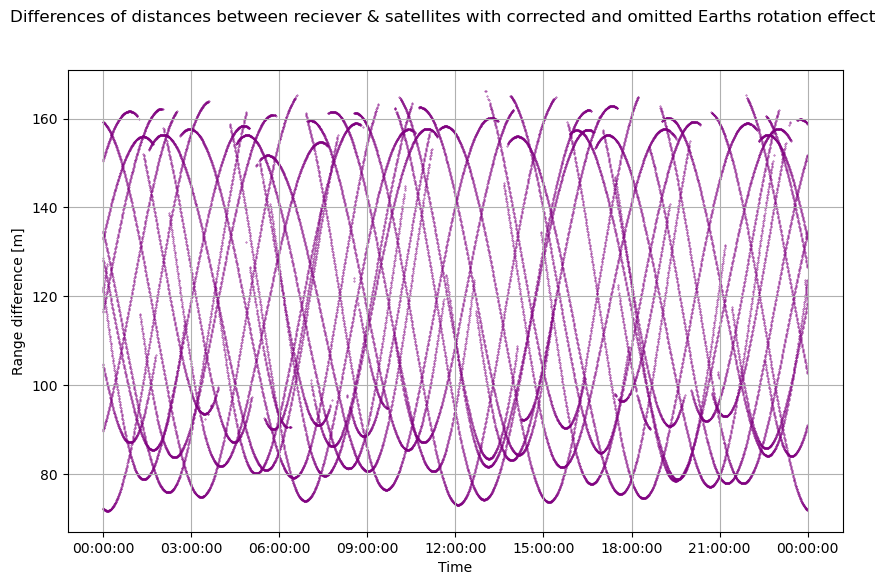

In [18]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
fig, ax = plt.subplots(1,1,figsize=(10,6))
fig.suptitle('Differences of distances between reciever & satellites with corrected and omitted Earths rotation effect')
for ind, gr in dPos.groupby('sv'):
    gr = gr.reset_index()
    ax.scatter(gr['time'], gr['dr'], label=ind,s=0.1,c='purple')
ax.set_ylabel('Range difference [m]')
ax.set_xlabel('Time')
ax.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

In [19]:
df_head(obs_crd[['xe','ye','ze','ev','az']],nrows=3,ncols=10, truncate_str=10,floatfmt='.1f')


| sv   | time                |         xe |         ye |        ze |   ev |    az |
|------|---------------------|------------|------------|-----------|------|-------|
| G02  | 2024-02-04 00:00:00 | 21576480.1 | 12769272.0 | 9640929.7 | 47.9 | 156.3 |
| G02  | 2024-02-04 00:00:30 | 21595863.1 | 12798076.7 | 9555185.5 | 47.7 | 156.3 |
| G02  | 2024-02-04 00:01:00 | 21615075.1 | 12826621.3 | 9469264.5 | 47.5 | 156.4 |

At this point, we have already developed most of the elements needed for positioning: satellite coordinates and clocks, elevation and azimuth. Now let's filter out low-elevation satellites and calculate the ionospheric and tropospheric corrections. Three ionosphere models have been implemented in GNX-py: Klobuchar [@Klobuchar1987], NTCM [@NTCMG2023], and interpolation from GIM products [@Schaer1998IONEX]. Let's use the Klobuchar model using the previously obtained GPSA and GPSB coefficients. The equations for the Klobuchar model are presented below:

In [20]:
obs_crd = obs_crd[obs_crd['ev']>7]

*Inputs in semicircles unless noted;* $E$ = elevation (semicircles), $A$ = azimuth (rad).


$$\begin{aligned}
\psi &= \frac{0.0137}{E+0.11}-0.022 && \qquad \text{Earth-centered angle} \\
\phi_I &= \phi_u + \psi\cos A,\quad \phi_I\in[-0.416,\,0.416] && \qquad \text{IPP latitude} \\
\lambda_I &= \lambda_u + \frac{\psi\sin A}{\cos\phi_I} && \qquad \text{IPP longitude} \\
\phi_m &= \phi_I + 0.064\cos(\lambda_I-1.617) && \qquad \text{Geomagnetic latitude at IPP} \\
t' &= \big(43200\,\lambda_I + t_{\rm GPS}\big)\bmod 86400 && \qquad \text{Local time (GPS SOW)} \\
A_I &= \sum_{n=0}^3 \alpha_n \phi_m^n,\quad A_I\ge 0 && \qquad \text{Amplitude of ionospheric delay} \\
P_I &= \sum_{n=0}^3 \beta_n \phi_m^n,\quad P_I\ge 72000 && \qquad \text{Period of ionospheric delay (s)} \\
X_I &= \frac{2\pi\,(t'-50400)}{P_I} && \qquad \text{Phase of ionospheric delay} \\
F &= 1 + 16(0.53 - E)^3 && \qquad \text{Slant factor} \\
I_{L1} &=
\begin{cases}
\big[5{\cdot}10^{-9} + A_I\big(1-\tfrac{X_I^2}{2}+\tfrac{X_I^4}{24}\big)\big]\,F, & |X_I|\le 1.57,\\[0.5ex]
5{\cdot}10^{-9}\,F, & |X_I|>1.57,
\end{cases}
&& \qquad \text{Ionospheric delay (seconds) at L1} \\
\Delta R &= c\,I_{L1},\qquad I_f = \left(\frac{f_{L1}}{f}\right)^2 I_{L1}
&& \qquad \text{Range effect and frequency scaling}
\end{aligned}$$



In [21]:
obs_crd=obs_crd.copy()
obs_crd.loc[:,'ion'] = obs_crd.apply(lambda row: gnx.klobuchar(azimuth=row['az'], elev=row['ev'],
                                                         fi=obs_data.meta[5][0],
                                                         lambda_=obs_data.meta[5][1],
                                                         tow=row['toc'],
                                                         alfa=nav_data.gpsa,
                                                         beta=nav_data.gpsb),axis=1)

Two different troposphere models are implemented: Saastamoinen [@Saastamoinen1972] and the Collins model [@Collins1999Troposphere]. In the case of PPP, however, Niell's mapping with ZTD estimation is used [@Niell1996]. For the simple SPP discussed here, the Saastamoinen model will be entirely sufficient. The model equations are presented below. The correction is calculated by calling the $saastamoinen()$ function.

**Saastamoinen tropospheric delay**

$$
\begin{aligned}
\epsilon &= |\mathrm{ev}|\cdot \frac{\pi}{180} \\[0.8ex]
P(h) &= Pr\left(1 - 2.26\times 10^{-5}h\right)^{5.225} \\[0.8ex]
T(h) &= Tr - 0.0065\,h \\[0.8ex]
H(h) &= Hr\,\exp\!\left(-6.396\times 10^{-4}h\right) \\[0.8ex]
e(h) &= 0.01\,H(h)\,
\exp\!\big( -37.2465 + 0.213166\,T(h) - 2.56908{\times}10^{-4}T(h)^2 \big)
\\[1.2ex]
\end{aligned}
$$

$$\begin{aligned}
d_{\text{trop}}(\epsilon,h)
&= \underbrace{\frac{0.002277}{\sin\epsilon}\!\left[P(h) - \frac{B(h)}{\tan^2\epsilon}\right]}_{\text{hydrostatic (dry) component}}
\;+\;
\underbrace{\frac{0.002277}{\sin\epsilon}\!\left(\frac{1255}{T(h)} + 0.05\right)e(h)}_{\text{wet component}}
\quad [\text{m}]
\end{aligned}$$



**Parameter definitions**

- **Elevation angle:**
  $\epsilon = |\mathrm{ev}|\cdot \pi/180$

- **Sea-level reference constants:**
  $Pr = 1013.25\ \mathrm{mbar},\quad Tr = 291.15\ \mathrm{K},\quad Hr = 50\%$

- **Pressure model:**
  $P(h) = Pr(1 - 2.26\times 10^{-5}h)^{5.225}$

- **Temperature profile:**
  $T(h) = Tr - 0.0065\,h$

- **Relative humidity vs. height:**
  $H(h) = Hr\,\exp(-6.396\times 10^{-4}h)$

- **Water vapor partial pressure:**
  $e(h) = 0.01\,H(h)\,\exp(-37.2465 + 0.213166T - 2.56908{\times}10^{-4}T^2)$

- **Dry mapping coefficient:**
  $B(h)$ obtained by linear interpolation between:

  heights
  $h_a = [0, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]$

  values
  $B_a = [1.156, 1.079, 1.006, 0.938, 0.874, 0.813, 0.757, 0.654, 0.563]$


In [22]:
obs_crd=obs_crd.copy()
obs_crd.loc[:,'tro'] = gnx.saastamoinen(ev=obs_crd['ev'].values, h=obs_data.meta[5][-1])

Relativistic path range correction is not necessary in SPP, as its effect is small and significantly below the accuracy of orbits and code observations, but nevertheless, for presentation purposes, we will calculate it below using the appropriate function. In PPP, it is worth introducing it, as it will interfere with positioning accuracy.


Relativistic Path Range Correction [@Ashby2003]:



$$\begin{aligned}
\rho_{\text{geom}} &= \left\| \mathbf r^{sat} - \mathbf r_{rcv} \right\|, \\[0.4ex]
\Delta \rho_{\text{rel}} &= \frac{2\,\mu}{c^2}\,\ln\!\left(\frac{r^{sat}+r_{rcv}+\rho_{\text{geom}}}{r^{sat}+r_{rcv}-\rho_{\text{geom}}}\right), \\[0.4ex]
\rho_{\text{corr}} &= \rho_{\text{geom}} + \Delta \rho_{\text{rel}} .
\end{aligned}$$



$$\begin{aligned}
\textbf{where:}\quad \\
& \mathbf r^{sat} \in \mathbb{R}^3 && \text{satellite ECEF position (m)},\\
& \mathbf r_{rcv} \in \mathbb{R}^3 && \text{receiver ECEF position (m)},\\
& \rho_{\text{geom}} && \text{Euclidean geometric range (m)},\\
& c = 299{,}792{,}458\ \text{m/s} && \text{speed of light},\\
& \mu = GM_\oplus \approx 3.986004418\times 10^{14}\ \text{m}^3/\text{s}^2 && \text{Earth's gravitational constant}.
\end{aligned}$$






In [23]:
obs_crd=obs_crd.copy()
obs_crd['dprel'] = gnx.rel_path_corr(rsat=obs_crd[['xe','ye','ze']], rrcv=obs_data.meta[4])

Magnitude of ionosphere and troposphere correction can be seen at the figure below:

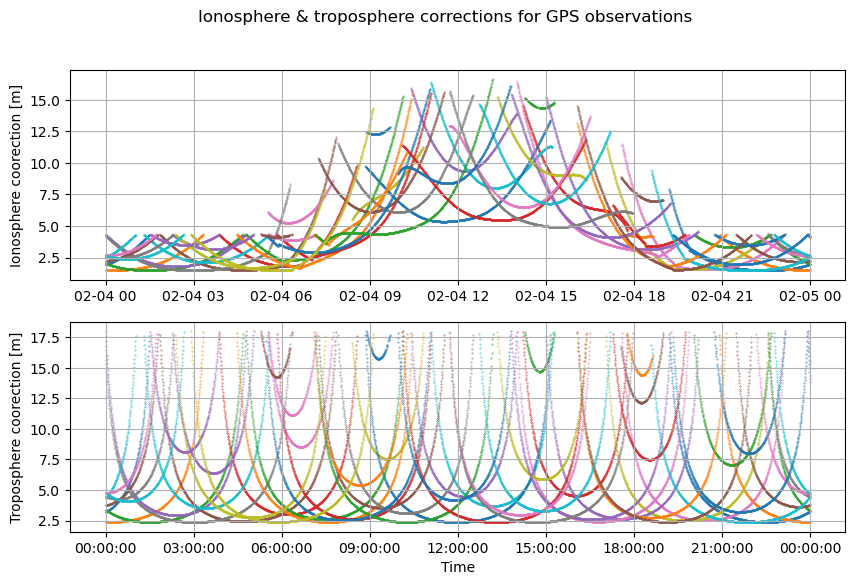

In [24]:

fig, ax = plt.subplots(2,1,figsize=(10,6))
fig.suptitle('Ionosphere & troposphere corrections for GPS observations')
for ind, gr in obs_crd.groupby('sv'):
    gr = gr.reset_index()
    ax[0].scatter(gr['time'], gr['ion'], label=ind,s=0.1)
    ax[1].scatter(gr['time'], gr['tro'], label=ind,s=0.1)
ax[0].set_ylabel('Ionosphere coorection [m]')
ax[1].set_ylabel('Troposphere coorection [m]')
ax[1].set_xlabel('Time')
ax[0].grid()
ax[1].grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))



Below you can see the scale of relativistic corrections for our observations.

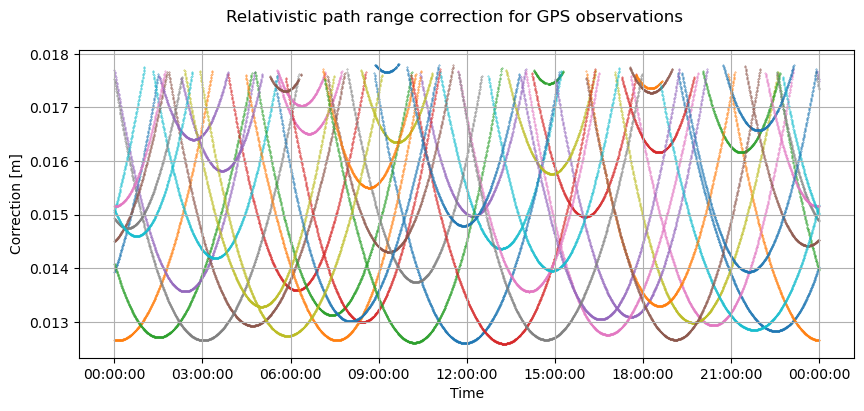

In [25]:
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
fig, ax = plt.subplots(1,1,figsize=(10,4))
fig.suptitle('Relativistic path range correction for GPS observations')
for ind, gr in obs_crd.groupby('sv'):
    gr = gr.reset_index()
    ax.scatter(gr['time'], gr['dprel'], label=ind,s=0.1)
ax.set_ylabel('Correction [m]')
ax.set_xlabel('Time')
ax.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))



The PCO of the receiver in the ANTEX file is given in the local topocentric coordinate system: East, North, Up. We can introduce them into the observation in two ways: either permanently correct the station position a-priori by the PCO vector converted to the ECEF system, or introduce the PCO correction as an amendment to the observation by projecting the vector onto the line-of-sight vector for the satellite-receiver pair. The default approach in GNX-py is the latter.

To calculate the line of sight vector, we need the approximate position of the station – we have obtained it from the RINEX file header.

In [26]:
xyz_apr = obs_data.meta[4].copy()


We will also write an auxiliary function that will ‘extract’ the PCO for a given system and signal. The PCO is given in millimetres, so we convert the value to metres.

In [27]:
def get_pco(rec_pco, sys):
    return np.array(next(v for k, v in rec_pco.items() if k[-1] == sys))/1000


In [28]:
rec_pco_l1 = gnx.enu_to_ecef(dENU=get_pco(rec_pco, "G01"),flh=obs_data.meta[5])
rec_pco_l2 = gnx.enu_to_ecef(dENU=get_pco(rec_pco, "G02"),flh=obs_data.meta[5])
print(f'Reciever PCO vectors in dENU:\n L1: {rec_pco_l1}\n L2: {rec_pco_l2}')

Reciever PCO vectors in dENU:
 L1: [0.05104749 0.01635834 0.07149983]
 L2: [0.06894601 0.02092454 0.09314551]


Our line-of-sight vector points from the receiver to the satellite. After projecting the PCO vector, we obtain a correction for a specific observation.

In [29]:
dxyz = -(obs_crd[['xe','ye','ze']].to_numpy() - xyz_apr)
dnorm = np.linalg.norm(dxyz,axis=1).reshape(-1,1)
los = dxyz/dnorm
pco_los_l1 = np.sum(los*rec_pco_l1,axis=1)
pco_los_l2 = np.sum(los*rec_pco_l2,axis=1)
obs_crd=obs_crd.copy()
obs_crd.loc[:,'pco_los_l1'] = pco_los_l1
obs_crd.loc[:,'pco_los_l2'] = pco_los_l2


In [30]:
df_head(obs_crd[['pco_los_l1','pco_los_l2']],nrows=3,ncols=4)

| sv   | time                |   pco_los_l1 |   pco_los_l2 |
|------|---------------------|--------------|--------------|
| G02  | 2024-02-04 00:00:00 |       -0.066 |       -0.087 |
| G02  | 2024-02-04 00:00:30 |       -0.065 |       -0.087 |
| G02  | 2024-02-04 00:01:00 |       -0.065 |       -0.087 |

The height of the antenna can be treated in the same way as PCO, taking into account that it is, of course, independent of the frequency of the signal used. Like PCO, it is given in a topocentric system. Therefore, we convert the antenna height offset to ECEF and project it onto the line-of-sight.

In [31]:
ant_h = obs_data.meta[3] # Up, East, North
ant_h = np.array([ant_h[1], ant_h[2], ant_h[0]])
ant_h_ecef = gnx.enu_to_ecef(dENU=ant_h,flh=obs_data.meta[5])
ah_los =  np.sum(los*ant_h_ecef,axis=1)
obs_crd = obs_crd.copy()
obs_crd.loc[:,'ah_los'] = ah_los

With the data prepared in this way, let's create a short script for SPP and perform positioning based on iono-free observations and uncombined observations  with the Klobuchar model. First, let's read the SINEX file for a given day to obtain the reference position with  $parse\_sinex()$ function. This will allow us to evaluate the positioning accuracy.

In [32]:
SINEX='/Users/hubertpierzchala/Desktop/GPSlib/art_data_package/IGS0OPSSNX_20240350000_01D_01D_CRD.SNX'
snx = gnx.parse_sinex(SINEX)

In [33]:
ref = snx.loc['BOR1'].to_numpy()
ref_flh = gnx.ecef2geodetic(ref)

Our a-priori position is the one we took from RINEX file header.

In [34]:
print(f'Reference coordinates: ECEF: {ref.round(3)}\nGeodetic: {ref_flh}\nA-priori coordinates: {xyz_apr}')

Reference coordinates: ECEF: [3738358.133 1148174.009 5021815.934]
Geodetic: [ 52.27695923  17.07346199 124.35793091]
A-priori coordinates: [3738358.5958 1148173.5785 5021815.7483]


Below you will find a simple script that performs SPP. It is not an advanced program, but it will allow us to verify the correctness of the above steps. You will find a description of the code in the comments in the cell below.

In [35]:
import pandas as pd
import numpy as np
# We define constants for ionofree combinations, speed of light, and list of results.
dtr = 0
f1=1575.42e06
f2= 1227.60e06
k1 = f1**2/(f1**2-f2**2)
k2 = f2**2/(f1**2-f2**2)
C=299792458
out = []



def hjacobian(x,sats):
    A = np.zeros(shape=(len(sats),4))
    dxyz = -(sats-x[:3])
    dnorm = np.linalg.norm(dxyz,axis=1)
    for i in range(len(sats)):
        A[i,:] = [dxyz[i,0]/dnorm[i],dxyz[i,1]/dnorm[i],dxyz[i,2]/dnorm[i],1]
    return A

def hx(x,sats):
    dxyz = -(sats-x[:3])
    dist = np.sqrt(dxyz[:,0]**2 + dxyz[:,1]**2 + dxyz[:,2]**2)
    return dist + x[-1]


for num, (t, gr) in enumerate(obs_crd.groupby('time')):

    # We select observations above 10 degrees of elevation - a reasonable threshold.
    # gr=gr[gr['ev']>10]
    #We create a plan matrix - A, its dimensions are (N,4), where N is the number of observations,
    # and 4 corresponds to our state vector - the receiver position and clock.
    A = np.zeros(shape=(len(gr),4))
    #The elements of the state vector are the components of the line of sight vectors.
    dxyz = -(gr[['xe','ye','ze']].to_numpy() - xyz_apr)
    dnorm = np.linalg.norm(dxyz,axis=1)
    for i in range(len(gr)):
        A[i,:] = [dxyz[i,0]/dnorm[i],dxyz[i,1]/dnorm[i],dxyz[i,2]/dnorm[i],1]
    # We determine the weight matrix—let us assume an observation error of 0.5 at the zenith for both observation types.
    err = np.diag(0.5/np.sin(np.deg2rad(gr['ev']))**2)
    P = np.linalg.inv(err)
    Psf = P.copy()
    # We create our observation vector. Please note that for the ionofree combination, we do not introduce the ionosphere or TGD – the receiver clocks are referenced to the IF C1W-C2W combination,
    # we have C1C-C2W, but we do not have DCB between C1C-C1W.
    # However, we introduce TGD into the observation at a single frequency.  You can choose not to introduce it and see what happens.
    observed = np.asarray((k1*gr['C1C'] - k2*gr['C2W']) - gr['tro'] + gr['clk']*C-gr['dprel'] + (k1*gr['pco_los_l1'] - k2*gr['pco_los_l2'])+ gr['ah_los'])
    observed_sf =np.asarray(gr['C1C'] - gr['tro'] + (gr['clk']-gr['TGD'])*C-gr['dprel'] - gr['ion'] + gr['pco_los_l1'] + gr['ah_los'])
    # Our “calculated” value is simply the geometric distance.
    computed = gnx.calculate_distance(gr[['xe','ye','ze']].values, xyz_apr)

    L = observed-computed
    Lsf = observed_sf-computed
    # A very simple element of the observation sanity check—we filter out observations based on a 3-sigma filter on prefit residuals.
    # This will allow us to protect ourselves against clock jumps.
    md = np.median(L)
    mask = np.where(np.abs(L) > 3*md)
    if len(mask[0]) < len(gr)/2:
        for ind in mask:
            P[ind, ind]/=100
    # LSQ solution for IF
    Q = np.linalg.inv(A.T@P@A)
    X = Q.dot(A.T.dot(P).dot(L))

    # The same sanity check for SF observations.
    md = np.median(Lsf)
    mask = np.where(np.abs(Lsf) > 3*md)
    if len(mask[0]) < len(gr)/2:
        for ind in mask:
            Psf[ind, ind]/=100
    # LSQ for SF
    Q = np.linalg.inv(A.T@Psf@A)
    Xsf = Q.dot(A.T.dot(Psf).dot(Lsf))
    # Corrections to observations
    V = A.dot(X)-L
    Vsf = A.dot(Xsf)-Lsf
    obs_crd=obs_crd.copy()
    obs_crd.loc[gr.index,'V']=V
    obs_crd.loc[gr.index,'Vsf']=Vsf
    # We collect results from both modes.
    dtr = X[3]
    obl_sf = xyz_apr+Xsf[0:3]
    obl = xyz_apr+X[0:3]

    dtrsf = Xsf[3]
    dif=ref-obl
    dif_sf=ref-obl_sf
    # Convert positioning errors to ENU coordinates.
    denu = gnx.ecef_to_enu(dif,flh=ref_flh)
    denu_sf = gnx.ecef_to_enu(dif_sf,flh=ref_flh)




    out.append(pd.DataFrame({'time':[t],'de':denu[0],'dn':denu[1],'du':denu[2],'dtr':[dtr],
                             'de_sf':denu_sf[0],'dn_sf':denu_sf[1],'du_sf':denu_sf[2],'dtr_sf':dtrsf}
                             ))
    # print(f'Processing: {obs_data.meta[0]} epoch: {t} \n Error IF: {denu}\n Error SF: {denu_sf}\n')
    # print('-----'*10)



Let's visualise our results. Below, I will show you how to use completely ordinary Python code to visualise positioning results. This is a major advantage of GNX-py – the simplicity of integrating popular Python libraries such as pandas and matplotlib to manage results and data.

In [36]:
result = pd.concat(out)
df_head(result,nrows=3,ncols=10,floatfmt='.1f')


|   index | time                |   de |   dn |   du |    dtr |   de_sf |   dn_sf |   du_sf |   dtr_sf |
|---------|---------------------|------|------|------|--------|---------|---------|---------|----------|
|     0.0 | 2024-02-04 00:00:00 | -0.7 | -0.8 | -2.8 | 2420.8 |     0.0 |    -1.6 |    -1.2 |   2426.9 |
|     0.0 | 2024-02-04 00:00:30 |  0.0 | -0.9 | -4.5 | 2421.9 |     0.3 |    -1.6 |    -1.4 |   2427.0 |
|     0.0 | 2024-02-04 00:01:00 | -0.3 | -0.6 | -2.6 | 2420.8 |     0.2 |    -1.6 |    -1.0 |   2426.8 |

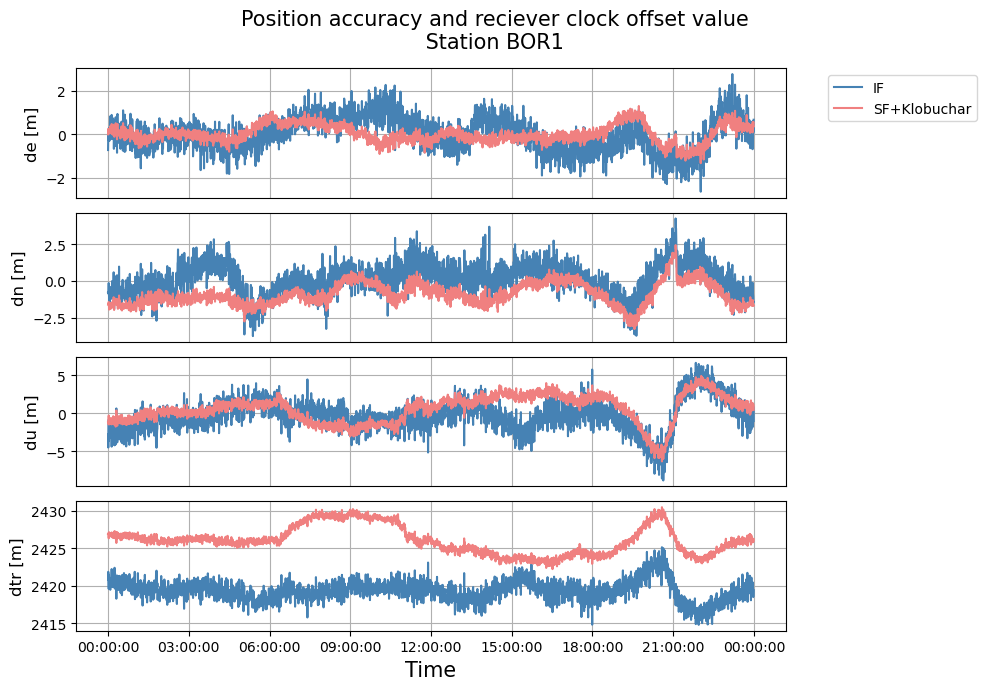

In [37]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
cols = ['de', 'dn', 'du', 'dtr']
fig.suptitle(f'Position accuracy and reciever clock offset value\n Station {obs_data.meta[0]} ',fontsize=15)
for i, col in enumerate(cols):
    ax[i].plot(result['time'], result[col], c='steelblue',label='IF')
    ax[i].plot(result['time'], result[f'{col}_sf'], c='lightcoral',label='SF+Klobuchar')
    ax[i].set_ylabel(f'{col} [m]',fontsize=12)
    ax[i].grid()
    if i < len(cols) - 1:
        ax[i].tick_params(axis='x', which='both', labelbottom=False, bottom=False)
ax[0].legend(loc='best',bbox_to_anchor=(1.05, 1), ncol=1)

# format and show x-axis (czas) only on the last subplot
ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax[-1].set_xlabel('Time',fontsize=15)

plt.tight_layout()


What you see above is the accuracy of our positioning: errors in the East, North and Up planes, and clock offset. We have nothing to compare the latter with, so we simply visualise it. The graph above illustrates what you can often read in textbooks on GNSS – iono-free observations are free from the influence of the ionosphere at the cost of increased noise caused by the linear combination of observations, while single-frequency observations are less noisy than iono-free ones, but require ionosphere modelling [@Handbook; @HofmannWellenhof2008]. Observing the differences in clock offset values, we see another characteristic feature: differences in clock delay for different frequencies. Let us also visualise the post-fit observation residuals. Once again, we see the effect I described above – IF residuals suffer from more noise than SF residuals.


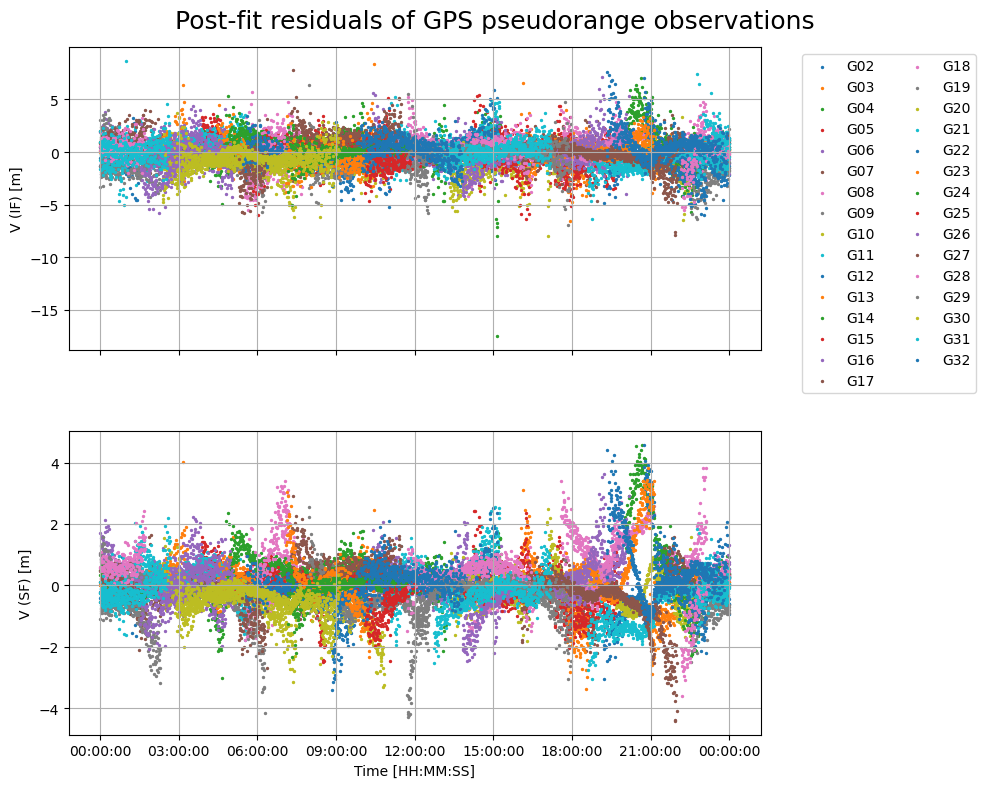

In [38]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

fig.suptitle('Post-fit residuals of GPS pseudorange observations', fontsize=18)

for sv, gr in obs_crd.groupby('sv'):
    ax[0].scatter(gr.index.get_level_values('time'), gr['V'], label=sv, s=2)
    ax[1].scatter(gr.index.get_level_values('time'), gr['Vsf'], label=sv, s=2)

ax[0].set_ylabel('V (IF) [m]', fontsize=10)
ax[1].set_ylabel('V (SF) [m]', fontsize=10)
ax[1].set_xlabel('Time [HH:MM:SS]', fontsize=10)

for i in range(2):
    ax[i].grid()
    ax[i].xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))

# legenda tylko na górnym wykresie
ax[0].legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=2)

plt.tight_layout()
plt.show()


Let us examine the RMS values broken down into components and in 3D.

In [39]:
cols = ['de', 'dn', 'du']
for i, col in enumerate(cols):
    pif = np.sqrt(np.mean(result[col]**2))
    sf = np.sqrt(np.mean(result[f'{col}_sf']**2))
    print(f'{col.upper()} RMS  IF: {pif:.2f} | SF: {sf:.2f}| meters')


DE RMS  IF: 0.78 | SF: 0.42| meters
DN RMS  IF: 1.10 | SF: 1.18| meters
DU RMS  IF: 2.11 | SF: 1.95| meters


In [40]:
result['3d_if'] = np.sqrt(result['de']**2 + result['dn']**2 + result['du']**2)
result['3d_sf'] = np.sqrt(result['de_sf']**2 + result['dn_sf']**2 + result['du_sf']**2)


In [41]:
for c in ['if','sf']:
    rms = np.sqrt(np.mean(result[f'3d_{c}']**2))
    print(f'{c.upper()} 3D RMS: {rms:.03f}' )

IF 3D RMS: 2.505
SF 3D RMS: 2.317


Interestingly, the SF solution with the klobuchar model proved to be slightly more accurate in terms of RMS than the IF solution.

***SPP Pipeline in GNX-py***

Above, we have implemented a series of steps to obtain positioning results. All of our preparations are contained in the SPPSession class, which takes an instance of the SPPConfig class as an argument, which is a class that stores the configuration parameters of our positioning. This is the basic way of implementing things in GNX-py: a configuration class for management and an execution class for the given configuration, which ‘hides’ all the complex code from us.

In [42]:
NAME ='BOR1'
DOY=35
config = gnx.SPPConfig(
                    obs_path=OBS,
                    nav_path=NAV,
                    sp3_path=None,
                    atx_path=ATX,
                    dcb_path=None,
                    gim_path=None,
                    sinex_path=SINEX,
                    use_gfz=True,
                    output_dir = './output',

                    sys='G',
                    gps_freq='L1',
                    gal_freq='E1',

                    screen=False,
                    orbit_type='broadcast',
                    broadcast_tolerance='2H',

                    ionosphere_model='klobuchar',
                    troposphere_model='saastamoinen',
                    sat_pco=False,
                    rec_pco=True,
                    windup=False,
                    rel_path=True,
                    solid_tides=False,
                    antenna_h =True,
                    ev_mask=7,


                    time_limit=None,
                    station_name=NAME,
                    day_of_year=DOY,

                    solver='LS' # in future: KF/ EKF
)

In [43]:
controller = gnx.SPPSession(config)

In [44]:
spp_results = controller.run()

In [45]:
for f in fields(spp_results):
    print(f.name, f.type)

solution typing.Optional[ForwardRef('pd.DataFrame')]
residuals_gps typing.Optional[ForwardRef('pd.DataFrame')]
residuals_gal typing.Optional[ForwardRef('pd.DataFrame')]
covariance_info typing.Optional[ForwardRef('pd.DataFrame')]


The result is a structure - a dataclass containing the results. $solution$ - these are the estimated state vector parameters, i.e. the receiver's position and clock. $residuals\_gps$ and (optionally) $residuals\_gal$ are residual-enriched dataframe with observations, and $covariance\_info$ contains elements of the covariance matrix of the determined parameters in each epoch. Use pandas and matplotlib tools to compare the results from our tutorial with those from SPPSession – you should obtain the same results with a difference of $1^{-5}$ metres.

In [46]:
residuals = spp_results.residuals_gps

In this chapter, you learned about an example of data processing using the GNX-py library. You performed steps from loading data to visualising positioning results. Finally, you learned about the SPPConfig and SPPSession classes, which allow you to perform the same task without having to write your own code. In the following notebooks, I will discuss the use of similar functionalities for positioning in PPP mode, orbit analysis, and ionosphere monitoring and modelling. In each case, the user interface is similar: configure the configuration class and pass it to the execution class (SPPConfig -> SPPSession). In the Library folder, you will find .py scripts such as: SPPSession, PPPSession, STECSession, SISSession. These are scripts that allow you to run your own pipeline for multiple observation files or even data from multiple days, where you only need to replace the appropriate paths to get the results. After reading the subsequent notebooks in this tutorial, you will know what to enter and where to enter it in order to perform the desired task.

Let me give you some additional information about the library that will help you understand its current capabilities. The GNX-py library is part of a larger project that I want to develop. Its goal is to create a convenient tool for obtaining data for scientific research, but also, as far as possible, to popularise and provide scientific assistance to students and GNSS enthusiasts. The current version of the library is the first ‘operational’ version and is not yet a fully comprehensive tool. Currently, the library only supports RINEX 3.0 files for observation and navigation files. The supported systems are GPS and Galileo. In terms of positioning, within these systems, the library processes a maximum of two signals at a time, in any configuration (e.g. L1L2, L1L5, E1E5a, E1E5b, etc.). Some elements are still waiting their turn in the queue for optimisation, primarily data loading and functions that calculate certain corrections. If you encounter any bugs, please do not hesitate to start a thread on GitHub.

I invite you to read the following chapters of the tutorial. I recommend the following order:
- Introduction (since you are reading this, you have already finished it)
- PPP
- Orbits
- Ionosphere

In some stages, we will use data from previous notebooks, hence this order.
